In [ ]:
import numpy as np
import torch
import torch.nn as nn
import random
import math
import collections 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
import os
import time
import torch.optim as optim


#check if cuda is available on the device or else default to the cpu usage

bool = torch.cuda.is_available() #checking if the presence of cuda is true
device = torch.device("cuda" if bool==True else "cpu") #choose to use device with cuda or cpu based on presence of cuda [Reference link : https://pytorch.org/docs/stable/cuda.html]
print(device)



cpu


In [26]:
#function that computes the eucledian distance between the various vertices.
def compute_dist_mat(cordinateMatrixRecieved):
    #uses the eucledian formulae to calculate the distance of eachval
    return np.sum((cordinateMatrixRecieved[:,:] - cordinateMatrixRecieved[:, None])*(cordinateMatrixRecieved[None,:] - cordinateMatrixRecieved[:, None]), -1)**(1/2)  #[Reference link : http://people.duke.edu/~ccc14/sta-663-2016/03A_Numbers.html]

def return_the_graph_matrix(n=5):
    cordinateMatrix = np.random.rand(n,2)
    distanceMatrix = np.sum((cordinateMatrix[:,:] - cordinateMatrix[:, None])*(cordinateMatrix[None,:] - cordinateMatrix[:, None]), -1)**(1/2)  #[Reference link : http://people.duke.edu/~ccc14/sta-663-2016/03A_Numbers.html]
    return cordinateMatrix,distanceMatrix


def get_graph(n , filename=""):
    GRAPH_NODE =n

    in_file=read_file(filename)
    coords=np.zeros((n,2),dtype=np.float)
    i=0;
    for _ in range(7):
        next(in_file)
    for line in in_file:
        values = map(lambda x: x, line.split(" "))
        values = list(values)
        if 'EOF\n' in values:
            break
        coord1=float(values[1])
        coord2=float(values[2])
        coords[i]=[coord1,coord2]
        i+=1;
    dist_mat = compute_dist_mat(coords)
    return coords, dist_mat

#function that will create and plot graph that is fully connected and the distance matrix between the nodes. [Eucledian distance]
def create_graph_matrix_and_plot(n=5): #function to create graph that reads in the number of nodes as input
    cordinateMatrix = np.random.rand(n,2) #creates a random matrix of size numberofnodes*2 which will be the values of cordinates of all cities [Reference link : https://stackoverflow.com/questions/15451958/simple-way-to-create-matrix-of-random-numbers]
    print("********************** GENERATING THE GRAPH ************************************")
    print("The cordinate matrix generated is shown below")
    print("")
    print(cordinateMatrix)  
    #dist_mat is the distance matrix computed
    distanceMatrix = np.sum((cordinateMatrix[:,:] - cordinateMatrix[:, None])*(cordinateMatrix[None,:] - cordinateMatrix[:, None]), -1)**(1/2)  #[Reference link : http://people.duke.edu/~ccc14/sta-663-2016/03A_Numbers.html]
    #printing the distance matrix
    print("")
    print("The distance matrix generated is shown below")
    print("")
    print(distanceMatrix)
    print("")
    #plotting the entire cordinated matrix on screen
    listVals = [] #creating a array of values of length cordmatrtix
    for i in range(len(cordinateMatrix)):
        listVals.append(100)   #appending values to the listVals 
    #crating two while loops to loop thorugh and plot each cordinate
    iterator1 = 0
    while(iterator1<len(cordinateMatrix)): #loop 1
        iterator2 = 0
        while(iterator2<len(cordinateMatrix)): #loop2
            if(iterator2>=iterator1):
                iterator2+=1 #skips loop if iterator2 > iterator1
                continue;
            else:
                arrayCreated1 = [] #stores latitude values
                arrayCreated2 = [] #stores longtitude values
                arrayCreated1.append(cordinateMatrix[iterator1,0])
                arrayCreated1.append(cordinateMatrix[iterator2,0]) #creates latittude values
                arrayCreated2.append(cordinateMatrix[iterator1,1])
                arrayCreated2.append(cordinateMatrix[iterator2,1]) #creates longtitude values [Reference link : https://kite.com/python/answers/how-to-draw-a-line-between-two-points-in-matplotlib-in-python]
                plt.title('Fully connected latitude/longtitude node graph')
                plt.xlabel('Latitude Values of each node')
                plt.ylabel('Longtitude Values of each node')
                plt.plot(arrayCreated1,arrayCreated2,color='red',marker="o",alpha=0.5) #creates the required plot #[Reference link : https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.plot.html]
                iterator2+=1
                
        iterator1+=1        
    print("******************************Graph Generationg Completed***********************")
    print(" ")
    return cordinateMatrix,distanceMatrix
    


In [27]:
#Here we will be creating a state for the solution the state will initially be a namedtuple from python
#the state consists of the following three things : 
#1)The distance matrix or the weights of the distances 
#2) the cordinates of all the nodes
#3)the visited nodes list

stateOfTheGraph = collections.namedtuple('State',('distanceMatix','cordinateMatrix','vistedList')) #[reference link : https://www.geeksforgeeks.org/namedtuple-in-python/]
print(stateOfTheGraph)
def fexponent(n):
    return math.exp(n)

def fsqrt(n):
    return math.sqrt(n)

<class '__main__.State'>


In [28]:
#The named tuple will then be converted to its corresponding torch tensor for further processing
def convert_to_tensor_from_state(stateval, statestatus=1):
    solutionset = set() #initializing a solution set to hold all values of the visited nodes 
    for eachval in stateval.vistedList:
        solutionset.add(eachval) #adds to the set all visited nodes
        
    firstLastVals =  [ stateval.vistedList[i] for i in (0, -1) ]  #stores the first and last values of a list using listcomprehension [Reference link : https://www.geeksforgeeks.org/python-get-first-and-last-elements-of-a-list/]   
    
    if(stateval.vistedList == []): #checks if list is empty [Reference link : https://therenegadecoder.com/code/how-to-check-if-a-list-is-empty-in-python/]
        last_node =  firstLastVals[1] #assigns the last node of list
    else:
        last_node = -1 #if no last node present assigns the value -1
    
    if(stateval.vistedList == []): #checks if list is empty [Reference link : https://therenegadecoder.com/code/how-to-check-if-a-list-is-empty-in-python/]
        first_node =  firstLastVals[0] #assigns the first node of list
    else:
        first_node = -1 #if no first node present assigns the value -1    
    
    cordinatesmat = stateval.cordinateMatrix #assingd the cordinate matrix
    
    valscreator = [] 
    iterator = 0
    while(iterator < cordinatesmat.shape[0]): #create an iterator that runs through the entire shape matrix
        arrval = []
        if(iterator in solutionset): #check is the val is present in solution and assings one else 0
            firstval = 1
        else:
            firstval = 0
        arrval.append(firstval)    
        if(iterator == first_node):  #check is the val is first node and assings one else 0
            secondval=1
        else:
            secondval=0
        arrval.append(secondval)    
        if(iterator == last_node): #check is the val is last node and assings one else 0
            thirdval=1
        else:
            thirdval=0
        arrval.append(thirdval)
        fourthval = cordinatesmat[iterator,0] #creates the latittude value 
        arrval.append(fourthval)
        fifthval =  cordinatesmat[iterator,1] #creates the longitude value 
        arrval.append(fifthval)
        valscreator.append(arrval)
        
        iterator = iterator + 1
    return torch.tensor(valscreator, dtype=torch.float32, requires_grad=False, device=device)

In [29]:
#creating the neural network model which is used to get the Q() function and paramterize it with input as state and output as vetor of acitons 
    
class QlearningNetwork(nn.Module):
  def __init__(self, dimension_for_embedding, Trials=4,extraparm1 = 4,extraparm2=5):       #creating a constructor class that will call super and also assign the various parameters [Reference link: https://pytorch.org/docs/stable/nn.html]
        #calling the super method
        super(QlearningNetwork, self).__init__()
        #assigning the number of dimensions as 5 holding the following 5 things
        self.extraparm1 = extraparm1
        self.extraparm2 = extraparm2
        a = fsqrt(dimension_for_embedding)
        #assiging the dimension_for_embedding parameters
        self.dimension_for_embedding = dimension_for_embedding
        #trails are created and assigned
        self.Trials = Trials
        onemoreval = 3+1
        varcreated = self.dimension_for_embedding #asssingning the self variable
        #Building the various theta modules [Reference link : https://pytorch.org/docs/stable/nn.html]
        self.theta1 = nn.Linear(2*2+1, varcreated if self.dimension_for_embedding !=5 else 5) #building theta1
        varcreated1 = nn.Linear(2,varcreated if self.dimension_for_embedding !=5 else 5)
        a = fexponent(self.extraparm1)
        self.theta2 = nn.Linear(varcreated if self.dimension_for_embedding !=5 else 5,varcreated if self.dimension_for_embedding !=5 else 5) #building theta2
        self.theta3 = nn.Linear(varcreated if self.dimension_for_embedding !=5 else 5, varcreated if self.dimension_for_embedding !=5 else 5) #building theta3
        a= fsqrt(a)
        self.theta4 = nn.Linear(3-2, varcreated if self.dimension_for_embedding !=5 else 5) #building theta4
        self.theta6 = nn.Linear(varcreated if self.dimension_for_embedding !=5 else 5, varcreated if self.dimension_for_embedding !=5 else 5) #building theta6
        a = fexponent(self.extraparm2)
        self.theta7 = nn.Linear(varcreated if self.dimension_for_embedding !=5 else 5, varcreated if self.dimension_for_embedding !=5 else 5) #building theta7
        
        iterator = 0
        self.theta8 = []
        while(iterator < 1):
            self.theta8.append(nn.Linear(varcreated if self.dimension_for_embedding !=5 else 5, varcreated if self.dimension_for_embedding !=5 else 5))
            iterator = iterator + 1
        self.theta5 = nn.Linear((3-1)*varcreated, 2-1) #building theta8
    
    #the forward pass of the the entire network will be using something of the nature nodefeatures holding node vals etd and graph features as input 
  def forward(self, nodeFeatures, graphs,extraparms1 = 0, extraparams2=1):
        
        varcreated = self.dimension_for_embedding #assignin the embedding dimesions to varcreated
        val = 4
        for i in range(4):
            val = val - 1 #storing val 
        val1 = 5
        for i in range(4):
            val1 = val1 - 1 #storing val1
        
        #assing the value of mu using the torch.zero [Reference link : https://pytorch.org/docs/stable/torch.html]
        the_mu_val = torch.zeros(nodeFeatures.shape[val], nodeFeatures.shape[val1], varcreated, device=torch.device("cuda" if bool==True else "cpu"))
        #print(nodeFeatures.shape[0])
        #print('hello')
        #assinging the graph values
        workedgraph = graphs
        #assigning the features
        workedfeatures = nodeFeatures
        working_trails = self.Trials
        #computing torch.one_like
        calcval =  torch.ones_like(graphs) #[Reference link : https://kite.com/python/docs/torch.ones_like]
        #computing torch.zeros_like
        calcval2 =  torch.zeros_like(graphs) #[Reference link : https://pytorch.org/cppdocs/api/function_namespacetorch_1a660c7003e58535ca935e0120c66a927e.html]
        #1-0 matrix 
        conn_matrices = torch.where(graphs > 0,calcval, calcval2)
        #moving to device
        conn_matrices= conn_matrices.to(torch.device("cuda" if bool==True else "cpu"))
        a = fexponent(extraparms1)
        #assigning theta1 values
        sval1=self.theta1(workedfeatures)
        #appending vals to array
        createdarray = []
        for everyval in self.theta8:
            createdarray.append(everyval)
        for everyval in createdarray:
            v = F.relu(sval1) #Creating a relu function [Refernce link : https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599/3]
            sval1 = everyval(v)
        #changing dimension    
        newval = workedgraph.unsqueeze(5-2)
        #getting the requisit vals
        count = 0
        sval3 = self.theta3(torch.sum(F.relu(self.theta4(newval)),dim=5-4)) #[Refernce link : https://stackoverflow.com/questions/44790670/torch-sum-a-tensor-along-an-axis]

        iterator = 0
        while(iterator < working_trails):
            #perfrom matrix multiplication
            sval2 = self.theta2(conn_matrices.matmul(the_mu_val))  #[Reference link : https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html]
            #new vals
            new = sval1 + sval2 
            new = new + sval3
            #mu updated
            the_mu_val = F.relu(new)
            iterator = iterator + 1
    
    
        #global and local states being generated
        sval = torch.sum(the_mu_val, dim=1, keepdim=True) #creating torch.sum #[Refernce link : https://stackoverflow.com/questions/44790670/torch-sum-a-tensor-along-an-axis]

        val1 = 5
        for i in range(4):
            val1 = val1 - 1 #storing val1     
        sval = sval.repeat(7-6,nodeFeatures.shape[val1],7-6) #repeating all vals
        #the global state 
        a= fsqrt(val1) #the_mu_val
        gs = self.theta6(sval) #theta6
        #print(gs)
        #the local state
        a= fsqrt(extraparams2) #sqrtvals
        count =0
        la = self.theta7(the_mu_val)   #theta7
        #print(la)
        
        arrval = []
        arrval.append(gs)
        arrval.append(la) #appending to arrval
        catval = torch.cat(arrval, dim=2) #cat concat
        o = F.relu(catval) #applying relu
        o = self.theta5(o) #[reference link : https://jamesmccaffrey.wordpress.com/2019/07/02/the-pytorch-view-reshape-squeeze-and-flatten-functions/]
        return o.squeeze(dim=8-6)
        
        
        

In [30]:
#this is for testing can be removed in further enhancements 




In [31]:
#creating a class called helper class that will work as a wrapper around the neural network
class helperclass():
    #creating a constructor initilalzing the various params in the system
    def __init__(self, createdmod, createdopt, createdlrsched, extraparms1=1,extraparms2=1): #creating the constuctor using the _init_ method
        self.createdmod = createdmod  # model from the previous class
        self.createdopt = createdopt #created optimizer vals
        self.createdlrsched = createdlrsched #created scheduler -> lr
        self.extraparms1 = extraparms1 #extraparms1
        self.extraparms2 = extraparms2 #extraparams
        self.loss_fn = nn.MSELoss()
        
        
    #creating a predictor function
    def future(self, ts, graphcreated,createdval1 =1,createdval =2):
        #torch.set_grad_enabled(False) #setting auto grad changes to false #[Reference link : https://stackoverflow.com/questions/53447345/pytorch-set-grad-enabledfalse-vs-with-no-grad]
        # print('model :', self.createdmod)
        with torch.no_grad():
            unsq1 = ts.unsqueeze(0) #[Reference link : https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch]
        #unsqueezing values in graphcreated
            unsq2 = graphcreated.unsqueeze(0)
            a= fsqrt(createdval1)
            # print('unsqeezed : ',unsq1," ::::::::::: ",unsq2)
        #returns the model
            valstoret = self.createdmod(unsq1, unsq2)
            return valstoret[0]
        #reset the grad back to true
        #torch.set_grad_enabled(F)

    #calculates the best action possible to get greedily    
    def get_best_action(self, ts, s,createdval1 =1,createdval =-1.9852041006088257):
        #assigns val to ts
        val = ts
        # print('val : ',val,' ::::::::: distmatrix: ',s.distanceMatix )
        arrayneeded = self.future(val, s.distanceMatix) #creates an array from the future function 
        indexofrewards = self.future(val, s.distanceMatix).argsort(descending=True) #[Refernce link : https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html]
        #indexofrewards = list(indexofrewards) #converts to list 
        a = fsqrt(createdval1)
        
        sol = s.vistedList #creates a visited list
        #solutionset = set() #initializing a solution set to hold all values of the visited nodes 
        #for eachval in s.vistedList:
        #    solutionset.add(eachval) #adds to the set all visited nodes
        #length = 0
        #for eachval in sol: #adds to solution
        #    length = length + 1
        
        #iterator =0
        
        solutionset = set(sol)
        #iterates through the array 
        for iterator in indexofrewards.tolist():
            if (len(sol)==0 or s.distanceMatix[sol[-1],iterator]>0) and iterator not in solutionset:
                return iterator, arrayneeded[iterator].item() 
       # return createdval1, createdval
            #if (length == 0 or  s.distanceMatix[sol[-1], iterator] > 0):
            #    if(iterator in solutionset):
                    #iterator = iterator + 1
            #        continue;
            #    else:
            #        return iterator.item(), arrayneeded[iterator].item() # specific return values
                    #iterator = iterator + 1
           # else:
              #  createdval = createdval +1
                #iterator = iterator +1
                
    #function to get the batch update working            
    def completeup(self, ts,graphcreated, a, t,createdval1 =1,createdval =2,):
        length = len(a)
        bool = torch.cuda.is_available() #checking if the presence of cuda is true
        ws = torch.stack(graphcreated) #staking and sending to cpu [reference link : https://stackoverflow.com/questions/52288635/how-to-use-torch-stack-function]
        newval = ws.to(torch.device("cuda" if bool==True else "cpu"))
        tv = torch.stack(ts) #stack and send to cpu
        newval2 = tv.to(torch.device("cuda" if bool==True else "cpu"))
        #zero grad optimizer 
        self.createdopt.zero_grad()
        
        rewardgot = self.createdmod(newval2,newval) #reward estimations
        #estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]    
        rewardarr = rewardgot[range(length),a] #calcaulating req rewards
        self.funcitonloss = nn.MSELoss() #creting a loss function
        a = fsqrt(createdval1)
        losscalculated = self.loss_fn(rewardarr, torch.tensor(t, device=torch.device("cuda" if bool==True else "cpu")))
        loss_val = losscalculated.item()
        
        #returning final values
        a = fsqrt(createdval1)
        losscalculated.backward()
        self.createdopt.step()        
        self.createdlrsched.step()
        
        return loss_val            

In [32]:
#creating an namedtuple to to store the various experiences : 
s = 'st' #state value
s1 = 'str1' #state reward values
s2 = 'a' #action values
s3 = 'r' #reward values
s4 = 'ns' #next state values
s5 = 'nst' #next state reward values
list1 = [] #created new list
list1.append(s)  #appedning s to the list
list1.append(s1) #appedning s1 to the list
list1.append(s2) #appedning s2 to the list
list1.append(s3) #appedning s3 to the list
list1.append(s4) #appedning s4 to the list
list1.append(s5) #appedning s5 to the list
createedtup = tuple(list1)  #converting list to tuple [Refrence link : https://www.geeksforgeeks.org/python-convert-a-list-into-a-tuple/]
encounter = collections.namedtuple('encounter',createedtup) #converting to named tuple for easier manipulation

class Remember(object): # a class to remeber to made decision
    
    def __init__(self, storage, required=1, needed=0): #constuctor class to initialize all values
            self.storage = storage #assigns an array of storage
            self.valueins = 0#invals
            self.required = 1 #requiredvals
            self.needed = 0 #neededval
            self.remember = [] #rememberance vals
            self.location = 0 #location vals
     
    #storing all know vals
    def remembevalr(self, experience,vals=1): #rembervalr
        vals = vals * 2 #val
        flag = 0 #setting flag = 0
        length = len(self.remember) #finding length
        
        flag = 0 if length < self.storage else 1 #flag=0 based on length
        if(flag==0): #checking vals
            val = None
            self.remember.append(val) #adding to remember
        val = self.location #location vals
        self.remember[val] = experience #adding to exp
        value = self.location + 1  #incrementing loc
        self.location = value % self.storage #finding modulus
        self.valueins = self.valueins + 1 #incrementing again
     
    #return a simple value of batch needed to return
    def batchvals(self, sizevals,needed=0,required=1):
        a = fsqrt(required)
        value1 = sizevals
        return random.sample(self.remember, value1) #[Reference link : https://www.geeksforgeeks.org/python-random-sample-function/]
    
    #return the length 
    def __len__(self):
        if(self.valueins <= self.storage): #checking the minimum value and returning it
            return self.valueins 
        else:
            return self.storage

In [33]:
#function that helps in finding the total distance
def distance_travelled(currentsol,graphobtained,coordinate_matrix,valreq=1): #calculates the total distance travelled
    lengthofsol = len(currentsol) #getting length of solution
    flag = 0 #setting flag to 0
    flag = 1 if lengthofsol < 2 else 0 #if less than 2 obviously there is not solution present
    if(flag==1):
        return 0
    else:
        travelled_distance = 0
        iterator = 0
        while(iterator < lengthofsol-1): #iteratring through entire solution and addiding distance
            val = currentsol[iterator]
            val1= currentsol[iterator+1]
            travelled_distance = travelled_distance + graphobtained[val,val1].item() #adding to the distance values
            iterator = iterator + 1 #incrementing iterator each time
        store = graphobtained.shape[0] #storing the graph shape
        flag = 0
        flag = 1 if lengthofsol == store else 0 #updating flag based on vals recieved
        if(flag==1):
            val = currentsol[-1]
            val1= currentsol[0]
            travelled_distance = travelled_distance + graphobtained[val,val1].item() #calculating the tolal distance value travelled
        if travelled_distance> MILEAGE and valreq==1:
            print('filling_fuel')
            last_city=currentsol[-1]
            coords_last=coordinate_matrix[last_city]
            fuel_coords=[coords_last[0]-2,coords_last[1]-1]
            fuel_dist=compute_eucledian(coords_last,fuel_coords)
            travelled_distance = travelled_distance + fuel_dist
        return travelled_distance


In [34]:
#function to determine if this the final state in solution
def final_state(s,val=1):
    create = set()
    for val in s.vistedList: #adding values and converting to a set
        create.add(val)
    if(len(create) == s.distanceMatix.shape[0]): #checking based on length
        return True
        #System.exit()
    else:
        return False

#eploring functinality to get the next neighbour
def explore_neighbour(s,cret1=1):
    currentsol = s.vistedList #assiging the states visited values
    graphobtained = s.distanceMatix #assiging the states graph
    legnthofsol = len(currentsol) #finding the length of solution
    flag = 0
    flag = 1 if legnthofsol == 0 else 0 #assiging flag based on length
    lister =[]
    for i in range(graphobtained.shape[0]): #appedning to list
        lister.append(i)
    if(flag == 1): #checking flag values
        return random.choice(lister) #using random choice to figure out
    create = set()
    for val in currentsol:
        create.add(val)
        
    newval = graphobtained[currentsol[-1]].nonzero() #creating the requist values using nonzero #[Refernce link : https://numpy.org/doc/1.18/reference/generated/numpy.nonzero.html]
    newval1 = filter(lambda n: n.item() not in create, newval)
    cand = list(newval1) #[Refernce link : https://www.geeksforgeeks.org/filter-in-python/]
    flag = 0 
    flag =1 if len(cand) == 0 else 0
    if(flag==1):
        return None
    else:
        return random.choice(cand).item()

In [49]:
#read all possible vals from arguments

#adding the various hyper parameters or the values used
SEED = 1  #using the seed values for setting up of all the random vals
GRAPH_NODE = 22  # Number of nodes for graph
EMBEDDIM = 5  # dimension of embedding
EMBEDDIMITERATOR = 1 #iterattion for embedding
EPISODES = 1000 #val of episodes
MEMORY = 10000 #memoryvals
QL_STEPS = 2  #qlearningsetps
SIZEOFBATCH = 22 #batchsize
GAMMAVAL = 0.9 #gammavals
MILEAGE = 100


INIT_LR = 5e-3 #intitialLrRate
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

NAME = 'capstone/.-models/'  # where to checkpoint the best models

In [51]:
#making a folder if one doesnt exist
def makefolder(val):
    flag = 1
    if(os.path.exists(val)):
        flag = 1
    else:
         flag =0
    if(flag==0):    
        os.makedirs(val)

#making the necessary filename        
def storefname(val,episodeval,avg_length):
    val2 = 'ep_{}'.format(episodeval)
    string = os.path.join(val, val2) + '_length_{}'.format(avg_length) + '.tar'
    return string
    
    
#creates and initilizes a model using the Qfunction()    
def modelintitialize(functionName=None,levels=1):
    #intilizing the Qleaning parms
    #Q_learnt = QlearningNetwork(EMBEDDIM, Trials=EMBEDDIMITERATOR).to(torch.device("cuda" if bool==True else "cpu"))
    Q_learnt = QlearningNetwork(EMBEDDIM, Trials=EMBEDDIMITERATOR).cpu()
    #declaring the optimizer with the parms and learning rate
    optimizer = optim.Adam(Q_learnt.parameters(), lr=INIT_LR,weight_decay=0) #adam '[Reference link : https://pytorch.org/docs/stable/optim.html]'
    #declaring teh lr_scheduler
    lr_scheduler1 = optim.lr_scheduler
    lr_scheduler = lr_scheduler1.ExponentialLR(optimizer, gamma=LR_DECAY_RATE) #[Refernce link : https://pytorch.org/docs/stable/optim.html]
    
    
    flag =0 
    flag = 1 if functionName is None else 0
    if(flag==0):
        savedNotion = torch.load(functionName) #loading the torch params #[Reference link : https://pytorch.org/tutorials/beginner/saving_loading_models.html]
        Q_learnt.load_state_dict(savedNotion['model']) #model from dict
    if(flag==0):    
        optimizer.load_state_dict(savedNotion['optimizer']) #optimizer from dict
        lr_scheduler.load_state_dict(savedNotion['lr_scheduler']) #scheduler from dict
    
    Q_returnerfunc = helperclass(Q_learnt, optimizer, lr_scheduler) #retunred val from function
    return Q_returnerfunc, Q_learnt, optimizer, lr_scheduler 



#creating the checkpoint model
def checkpoint_model(modelval, optimizerval, lr_schedulerval, lossfunc, 
                     episodeval, avg_lengthval,newval1=1,newval2=1):
    
    makefolder(NAME) #cereating a folder if one doesnt exist
    filename = storefname(NAME,episodeval,avg_lengthval) #making the filename
    #saving as a torch variable
    torch.save({'episode': episodeval,'model': modelval.state_dict(),'optimizer': optimizerval.state_dict(),'lr_scheduler': lr_schedulerval.state_dict(),'loss': lossfunc,'avg_length': avg_lengthval}, filename)


In [46]:
def function_impl(GRAPH_NODE):
  # seed everything for reproducible results first:
  torch.manual_seed(seed=SEED) # setting the seed value of the torch variables [Reference link : https://pytorch.org/docs/master/torch.html?highlight=manual_seed#torch.manual_seed]
  random.seed(SEED)
  np.random.seed(seed=SEED) # seed for numpy operation [Reference link : https://www.sharpsightlabs.com/blog/numpy-random-seed/]
  function, network, optim, schedule = modelintitialize() #calling the initilaize model phase
  # print('return values: ',function,network, optim, schedule)
  capactiy = Remember(MEMORY) #creating the memory for project
  #various vals and marks of training stored here
  sols = {} # storing the training vals for episodes
  losses = [] #storing a loss vals
  path_lengths= [] #storing the various lengths

  # keep track of median path length for model checkpointing
  minlength = sys.maxsize #created and intilized to a large number


  iterator = 0 #starting iterator at 0
  while(iterator < EPISODES): #iterating for all the episodes 
 
      coorindatematrix, graphmatrix = return_the_graph_matrix(GRAPH_NODE) #creating and calling the graph
      graphCreated = torch.tensor(graphmatrix, dtype=torch.float32, requires_grad=False, device=device) #converting to tensor
      solution = [] #partial solution created
      solution.append(random.randint(0, GRAPH_NODE-1)) #appending a random number
      counter = -1
      cs = stateOfTheGraph(vistedList=solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix) #getting the current state set
      cst = convert_to_tensor_from_state(cs) #converting state to tensor for computation

      #keeping track of replay memories
      states = []
      states.append(cs)
      states_tsrs = []
      states_tsrs.append(cst)
      re = []
      ac = []
      
      # current value of epsilon
      flag = 0
      flag = 1 if MIN_EPSILON > math.pow((1-EPSILON_DECAY_RATE),2) else 0 #math.pow is the cooling rate
      if(flag==1):
          eps = MIN_EPSILON
      else:
          #eps = math.pow((1-EPSILON_DECAY_RATE),2)
          eps =  (1-EPSILON_DECAY_RATE)**iterator
      nr_explores = 0
      #looping until we reach the final state
      while(final_state(cs)!=True):
          #incrementing counter value holding timestamp of the episode
          counter = counter + 1 

          val = random.random()
          flag = 0
          flag = 1 if eps >= val else 0
          #exploring values based of epsilon values
          if(flag==1):
              next1 = explore_neighbour(cs)
              nr_explores = nr_explores + 1
          #picking next best greedy option    
          else:
              next1, ereward = function.get_best_action(cst, cs) #get next node and the estimate reward
              flag = 0
              flag = 1 if iterator % 50 == 0 else 0
              if(flag==1):
                  print('Episode value: ' + str(iterator))
                  print('The present solution: ' + str(solution))
                  print('Reward Estimated Next: ' + str(ereward))
          next_solution = solution + [next1] #next solution optained

          # reward observed for taking this step   
          val1 = distance_travelled(solution,graphCreated,coorindatematrix)
          val2 = distance_travelled(next_solution,graphCreated,coorindatematrix)
          
          reward = val2-val1
          reward = -reward #reward obtained perfroming this
          
          #getting the next state as a named tuple and also converting it to a tensor
          ns = stateOfTheGraph(vistedList=next_solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix)
          nst = convert_to_tensor_from_state(ns)
          #storing all the relvant experience information
          states.append(ns)
          states_tsrs.append(nst)
          re.append(reward)
          ac.append(next1)
          #Using the q-lering with n step to store solutions
          flag =0
          valuelength  = len(solution)
          flag = 1 if valuelength >= QL_STEPS else 0
          if(flag ==1):
              capactiy.remembevalr(encounter(st=states[-QL_STEPS],str1=states_tsrs[-QL_STEPS],a=ac[-QL_STEPS],r=sum(re[-QL_STEPS:]),ns=ns,nst=nst))
          flag =0 
          flag = 1 if final_state(ns) else 0
          if(flag==1):
              iterator1 = 1
              while(iterator1 < QL_STEPS):
                  capactiy.remembevalr(encounter(st=states[-iterator1],str1=states_tsrs[-iterator1],a=ac[-iterator1],r=sum(re[-iterator1:]),ns=ns,nst=nst))
                  iterator1 = iterator1 +1
          #updating all values
          cs = ns
          cst = nst
          solution = next_solution
          
          #print(reached gradient step)
          #perfroming gradiaent operations
          #gradient steps
          loss = None
          flag=0
          flag1=0
          valuenlignth1 = len(capactiy) #value of memory
          flag = 1 if valuenlignth1 >= SIZEOFBATCH else 0 
          flag1= 1 if valuenlignth1 >=2000 else 0
          if(flag == 1 and flag1 ==1):
              storesvalsforprocessing = capactiy.batchvals(SIZEOFBATCH)
              batchst =[]
              batchWs = []
              batchac = []
              batchta= list([])
              for val in storesvalsforprocessing: #appending the required memory values
                  batchst.append(val.str1)
                  batchWs.append(val.st.distanceMatix)
                  batchac.append(val.a)
              #perfroming calculation for each experience value
              for e in storesvalsforprocessing:
                  target = e.r
                  flag =0
                  flag =1 if final_state(e.ns) else 2
                  if(flag==2):
                      _, best_reward = function.get_best_action(e.nst,e.ns)
                      valsnow = GAMMAVAL * best_reward
                      target = target + valsnow
                  batchta.append(target)
              #appending to loss 
              createdval1=5
              loss = function.completeup(batchst, batchWs, batchac, batchta,createdval1)
              losses.append(loss)

              #calculating median lengths
              calculatedmediaanvaluelength = np.median(path_lengths[-100:]) #[refernce link : https://docs.scipy.org/doc/numpy/reference/generated/numpy.median.html]
              flag =0
              
              flag = 1 if calculatedmediaanvaluelength < minlength else 0
              if(flag ==1):
                  minlength = calculatedmediaanvaluelength
                  newval1to10 = 5 
                  checkpoint_model(network, optim, schedule, loss, iterator, calculatedmediaanvaluelength,newval1to10)            
      length = distance_travelled(solution, graphCreated,coorindatematrix,0)
      path_lengths.append(length)
      flag=0
      val = iterator %10
      flag =1 if val ==0 else 0
      if(flag==1):
          print("Episide:" + str(iterator))
          if loss is None:
              print("loss:" + str(-1))
          else:
              print("loss : " + str(loss))
          print("median length : " + str(np.median(path_lengths[-50:])))
          print("last : " +str(length))
          print("epsilon val : " + str(eps))  
          print("the solution is below: ")
          print(solution)
          listnew = []
          for val in solution:
              listnew.append(val)
          sols[iterator] = (graphCreated.clone(), coorindatematrix.copy(),listnew)
      
      iterator = iterator + 1 
  plot_loss_avg(losses,path_lengths)

In [38]:
#function to calculate the moving averages of present functions
def _moving_avg(values, window, val=100): #reference link : [https://www.google.com/search?q=moving+average+plot+in+numpy&oq=moving+average+plot+in+numpy&aqs=chrome..69i57j33l2.8232j0j4&sourceid=chrome&ie=UTF-8#kpvalbx=_z56aXqW9KsW5tQaG95fQBA34]
    weights = np.repeat(1.0,window)/window
    values = np.array(values)
    movingavg = np.convolve(values,weights,'valid')
    return movingavg
    
def plot_loss_avg(losses,path_lengths):
  #funtion that plots the graph for loss v training iterations
  plt.figure(figsize=(16,10))
  plt.semilogy(_moving_avg(losses, 100)) #[Reference link : https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.semilogy.html]
  plt.title('Loss Vs Training Iteration Plot Graph')
  plt.ylabel('loss Values Calculate')
  plt.xlabel('training iteration')


In [39]:
def before_eg_sol():
  #adding all the file names obtained
    all_lengths_fnames = []
    for file in os.listdir(NAME):
        if(file.endswith('.tar')):
            all_lengths_fnames.append(file)

  #getting the shortest file name        
    shortnames = sorted(all_lengths_fnames, key=lambda y: float(y.split('.tar')[0].split('_')[-1]))[0] #change this
    print("shortest avg length found is :" )
    print(" ")
    print(shortnames.split('.tar')[0].split('_')[-1]) #change this


    #getting the checkpoitn vals
    function, network, optim, schedule = modelintitialize(os.path.join(NAME, shortnames))
    return function, network, optim, schedule


#solution plotter
def solutionplot(valofcords, matrixval, solVals,plotvalue=1,plotvalue1=2):
    iterator =0
    while(iterator<len(valofcords)-1):
        i = solVals[iterator]
        n = solVals[iterator+1]
        arrayCreated1 = []
        arrayCreated2 = []
        arrayCreated1.append(valofcords[i,0])
        arrayCreated1.append(valofcords[n,0]) #creates latittude values
        arrayCreated2.append(valofcords[i,1])
        arrayCreated2.append(valofcords[n,1]) #creates longtitude values
        plt.plot(arrayCreated1, arrayCreated2, color='red',marker="o",alpha=0.5)
        iterator = iterator + 1
    
    i = solVals[-1]
    n = solVals[0]
    arrayCreated1 = []
    arrayCreated2 = []
    arrayCreated1.append(valofcords[i,0])
    arrayCreated1.append(valofcords[n,0]) #creates latittude values
    arrayCreated2.append(valofcords[i,1])
    arrayCreated2.append(valofcords[n,1]) #creates longtitude values
    plt.plot(arrayCreated1, arrayCreated2, color='red',marker="o",alpha=0.5)
    plt.plot(valofcords[solVals[0], 0], valofcords[solVals[0], 1], 'x', markersize=10)
    
# test synthetically created data with the trained model for number of nodes=GRAPH_NODE
def example_solutions_synthetic(GRAPH_NODE):
  #some example sols    
    function, network, optim, schedule=before_eg_sol()
    for sample in range(10):
        coorindatematrix, graphmatrix = return_the_graph_matrix(GRAPH_NODE) #creating and calling the graph
        graphCreated = torch.tensor(graphmatrix, dtype=torch.float32, device=torch.device("cuda" if bool==True else "cpu")) #converting to tensor
        solution = [] #partial solution created
        randomval = random.randint(0, GRAPH_NODE-1)
        solution.append(randomval) #appending a random number
        cs = stateOfTheGraph(vistedList=solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix) #getting the current state set
        cst = convert_to_tensor_from_state(cs) #converting state to tensor for computation

        while not final_state(cs):
            next1, ereward = function.get_best_action(cst, cs)
            solution = solution + [next1]
            cs = stateOfTheGraph(vistedList=solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix)
            cst = convert_to_tensor_from_state(cs)

        plt.figure()
        solutionplot(coorindatematrix, graphCreated, solution)
        plt.xlabel('Latitude Values of each node')
        plt.ylabel('Longtitude Values of each node')
        value = distance_travelled(solution, graphCreated,coorindatematrix,0)
        plt.title('Distance Calculated by model = ' + str(value))


In [40]:
def before_eg_sol():
  #adding all the file names obtained
  all_lengths_fnames = []
  for file in os.listdir(NAME):
      if(file.endswith('.tar')):
          all_lengths_fnames.append(file)

  #getting the shortest file name        
  shortnames = sorted(all_lengths_fnames, key=lambda y: float(y.split('.tar')[0].split('_')[-1]))[0] #change this
  print("shortest avg length found is :" )
  print(" ")
  print(shortnames.split('.tar')[0].split('_')[-1]) #change this




  #getting the checkpoitn vals
  function, network, optim, schedule = modelintitialize(os.path.join(NAME, shortnames))
  #os.path.join(FOLDER_NAME, shortest_fname)
  return function, network, optim, schedule


#solution plotter

def solutionplot(valofcords, matrixval, solVals,plotvalue=1,plotvalue1=2):
    #plt.scatter(coords[:,0], coords[:,1])
    iterator =0
    while(iterator<len(valofcords)-1):
        i = solVals[iterator]
        n = solVals[iterator+1]
        arrayCreated1 = []
        arrayCreated2 = []
        arrayCreated1.append(valofcords[i,0])
        arrayCreated1.append(valofcords[n,0]) #creates latittude values
        arrayCreated2.append(valofcords[i,1])
        arrayCreated2.append(valofcords[n,1]) #creates longtitude values
        plt.plot(arrayCreated1, arrayCreated2, color='red',marker="o",alpha=0.5)
        iterator = iterator + 1
    
    i = solVals[-1]
    n = solVals[0]
    arrayCreated1 = []
    arrayCreated2 = []
    arrayCreated1.append(valofcords[i,0])
    arrayCreated1.append(valofcords[n,0]) #creates latittude values
    arrayCreated2.append(valofcords[i,1])
    arrayCreated2.append(valofcords[n,1]) #creates longtitude values
    plt.plot(arrayCreated1, arrayCreated2, color='red',marker="o",alpha=0.5)
    plt.plot(valofcords[solVals[0], 0], valofcords[solVals[0], 1], 'x', markersize=10)

def example_solutions():
  #some example sols    
  function, network, optim, schedule=before_eg_sol()
  for sample in range(1):
      coorindatematrix, graphmatrix = return_the_graph_matrix(filename) #creating and calling the graph
      graphCreated = torch.tensor(graphmatrix, dtype=torch.float32, device=torch.device("cuda" if bool==True else "cpu")) #converting to tensor
      solution = [] #partial solution created
      randomval = random.randint(0, GRAPH_NODE-1)
      solution.append(randomval) #appending a random number
      cs = stateOfTheGraph(vistedList=solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix) #getting the current state set
      cst = convert_to_tensor_from_state(cs) #converting state to tensor for computation
      
      while not final_state(cs):
          next1, ereward = function.get_best_action(cst, cs)
          solution = solution + [next1]
          cs = stateOfTheGraph(vistedList=solution, distanceMatix=graphCreated, cordinateMatrix=coorindatematrix)
          cst = convert_to_tensor_from_state(cs)
          
      plt.figure()
      solutionplot(coorindatematrix, graphCreated, solution)
      plt.xlabel('Latitude Values of each node')
      plt.ylabel('Longtitude Values of each node')
      value = distance_travelled(solution, graphCreated)
      plt.title('Distance Calculated by model = ' + str(value))
      
      # for comparison, plot a random solution
      plt.figure()
      random_solution = list(range(GRAPH_NODE))
      solutionplot(coorindatematrix, graphCreated, random_solution)
      plt.xlabel('Latitude Values of each node')
      plt.ylabel('Longtitude Values of each node')
      value = distance_travelled(random_solution, graphCreated)
      plt.title('Distance Calculated by random = ' + str(value))

In [41]:
solution = [] #partial solution created
solution.append(random.randint(0, GRAPH_NODE-1)) #appending a random number
print(solution)

[21]


In [42]:
def read_file(filename) :
    f = open(filename, "r")
    for line in f:
        yield line

# given number of nodes and filename(in case of realtime dataset), generates/ retrives graph with n
#number of nodes, computes distance matrix.
def get_graph(n , filename=""):
    GRAPH_NODE =n
    in_file=read_file(filename)
    coords=np.zeros((n,2),dtype=np.float)
    i=0;
    for _ in range(7):
        next(in_file)
    for line in in_file:
        values = map(lambda x: x, line.split(" "))
        values = list(values)
        if 'EOF\n' in values:
            break
        coord1=float(values[1])
        coord2=float(values[2])
        coords[i]=[coord1,coord2]
        i+=1;
    dist_mat = compute_dist_mat(coords)
    return coords, dist_mat


In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
!cp gdrive/My\ Drive/ADBI/capstone.zip .
!unzip capstone.zip


Archive:  capstone.zip
replace capstone/ulysses22.tsp/ulysses22.tsp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Episide:0
loss:-1
median length : 9.70003342628479
last : 9.70003342628479
epsilon val : 1.0
the solution is below: 
[4, 2, 17, 18, 8, 0, 16, 19, 15, 20, 13, 9, 1, 3, 14, 10, 12, 11, 6, 21, 7, 5]
Episide:10
loss:-1
median length : 11.389512360095978
last : 11.389512360095978
epsilon val : 0.994016174107196
the solution is below: 
[21, 7, 11, 9, 8, 2, 16, 18, 4, 19, 14, 13, 1, 20, 5, 10, 15, 0, 17, 6, 3, 12]
Episide:20
loss:-1
median length : 11.165655242279172
last : 7.73794321436435
epsilon val : 0.9880681543867074
the solution is below: 
[4, 1, 19, 11, 10, 21, 5, 20, 17, 2, 8, 12, 14, 3, 0, 15, 9, 18, 13, 6, 16, 7]
Episide:30
loss:-1
median length : 11.165655242279172
last : 12.038393197581172
epsilon val : 0.9821557265806331
the solution is below: 
[18, 16, 19, 21, 11, 7, 8, 5, 1, 17, 20, 15, 0, 12, 9, 4, 14, 13, 2, 3, 6, 10]
Episide:40
loss:-1
median length : 11.450939044356346
last : 11.614564567804337
epsilon val : 0.9762786777131541
the solution is below: 
[11, 10, 21, 7, 0, 19,

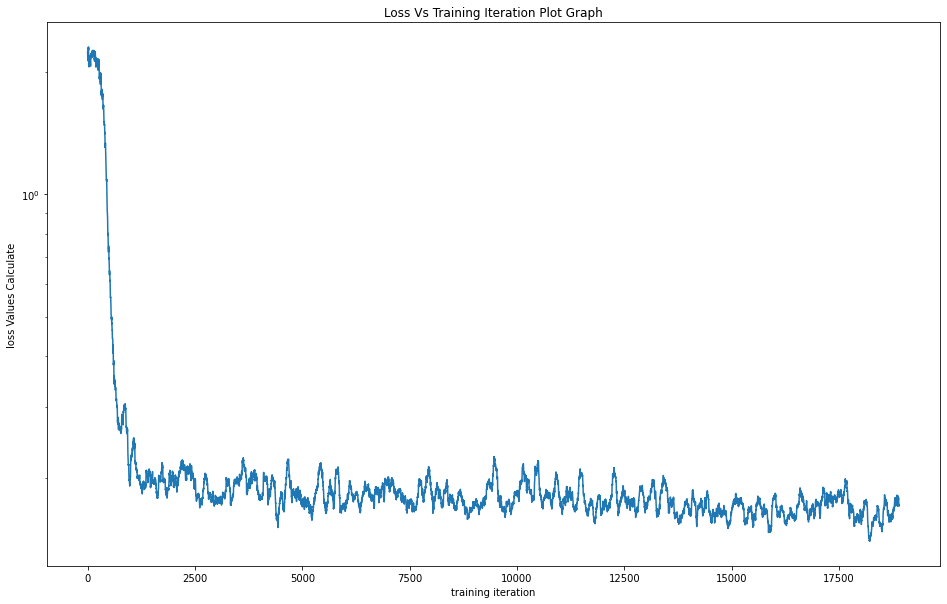

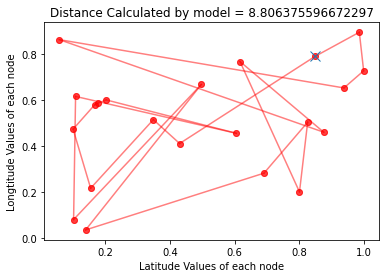

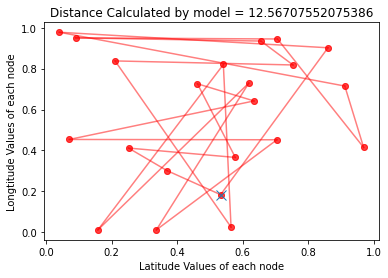

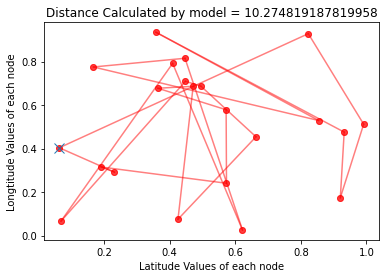

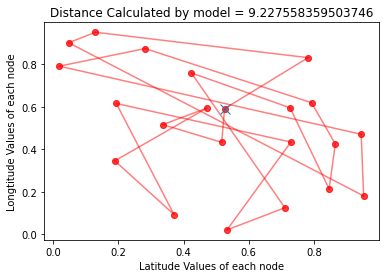

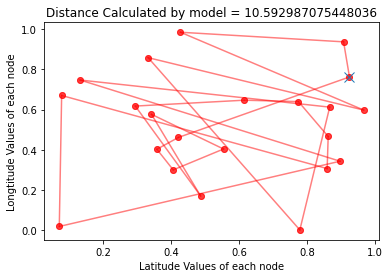

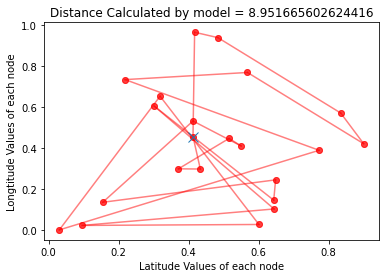

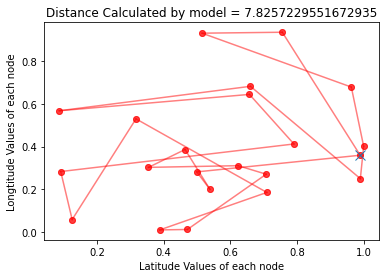

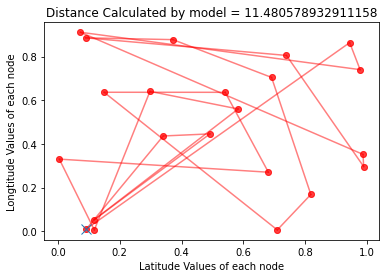

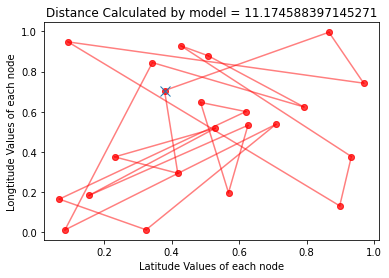

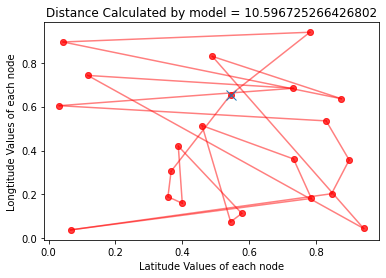

In [52]:
def main():
    no_nodes= input('enter the number of nodes(default: 22) : ')
    no_nodes=int(no_nodes)
    # hyper-parameter 
    GRAPH_NODE=no_nodes
    # implementation of Q-learning training with randomly generated synthetic dataset 
    function_impl(no_nodes)
    # real-time data available only for node sizes : 22, 52 and 100.
    data=input('do you want to run for \n1.synthetic data \n2.real-time data')
    if data=='1':
        # test and plot with generated dataset with given number of nodes
        example_solutions_synthetic(no_nodes)
    elif data=='2':
        # test with real dataset (ulysses22,berlin52 and kro100)
        example_solutions_real_data(GRAPH_NODE)
    else:
        print('invalid')
    
main()
